In [54]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline


# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [55]:
sub1test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-001_Resp_Test.npy")
sub2test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-002_Resp_Test.npy")
sub3test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-003_Resp_Test.npy")
sub4test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-004_Resp_Test.npy")
sub5test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-005_Resp_Test.npy")
print(sub1test.shape)
print(sub2test.shape)
print(sub3test.shape)
print(sub4test.shape)
print(sub5test.shape)

(60784, 4, 600)
(53927, 4, 600)
(64700, 4, 600)
(61899, 4, 600)
(53421, 4, 600)


Concatenate all of the data.

In [56]:
# Each element should be a NumPy array of shape [n_voxels, 4, 60]
subject_list = [sub1test, sub2test, sub3test, sub4test, sub5test]

Create a genre label vector to feed into the UMAP function.

In [57]:
# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract numeric genre IDs
genre_labels = []
for run in range(6):  # 6 runs
    for track_pos in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_pos])
        genre_labels.append(genre_id)  # values: 1–10

# Step 2: Repeat each genre label 4 times (for 4 reps)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

# Step 3: Repeat for 5 subjects
genre_labels_full_all = np.tile(genre_labels_full, 5)  # shape: (1200,)

# Step 4: Convert to names using the corrected mapping
genre_names = [
    'country',    # index 1
    'reggae',     # index 2
    'rock',       # index 3
    'blues',      # index 4
    'classical',  # index 5
    'hiphop',     # index 6
    'disco',      # index 7
    'jazz',       # index 8
    'metal',      # index 9
    'pop'         # index 10
]

# ✅ Create labeled vectors
genre_labels_named_240 = [genre_names[i - 1] for i in genre_labels_full]
genre_labels_named_1200 = [genre_names[i - 1] for i in genre_labels_full_all]

# ✅ Quick check
print("First 12:", genre_labels_named_240[:12])
print("First 12 of full set:", genre_labels_named_1200[:12])
print("Length 240:", len(genre_labels_named_240))
print("Length 1200:", len(genre_labels_named_1200))


First 12: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
First 12 of full set: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
Length 240: 240
Length 1200: 1200


PCA dimension reduction so we can stack the voxel info from the different subjects without getting errors about differently sized vectors:

POSSIBLE VARIATIONS:

scree plot - sanity check

use more PCs

change time points

average voxels across a period

run without genre categorization

run with training data to get more points

In [5]:
from sklearn.decomposition import PCA
import numpy as np

all_subjects_pca = []
all_genre_labels = []
all_subject_ids = []

for subject_idx, fmri_data in enumerate(subject_list):
    subject_samples = []
    
    #this extraction results in the following format:
        # track0_rep0
        # track0_rep1
        # track0_rep2
        # track0_rep3
        # track1_rep0
        # track1_rep1
        # track1_rep2
        # track1_rep3
        # ...
        # track59_rep3  
    for track_idx in range(60):
        for rep in range(4):
            t = track_idx * 10 + 8
            voxel_vector = fmri_data[:, rep, t]
            subject_samples.append(voxel_vector)

    subject_samples = np.stack(subject_samples)  # shape: [240, n_voxels]

    # Subject-wise PCA (to handle voxel count mismatch)
    pca = PCA(n_components=100)    # change PCs
    subject_pca = pca.fit_transform(subject_samples)  # shape: [240, 100]

    all_subjects_pca.append(subject_pca)
    all_genre_labels.extend(genre_labels_named_240)  # same 240 for each subject
    all_subject_ids.extend([subject_idx] * 240)

# Final combined matrix
data_matrix = np.vstack(all_subjects_pca)  # shape: [1200, 100]



In [6]:
# Sanity Check
print(data_matrix.shape)               # should be (1200, ...)
print(len(genre_labels_named_1200))     # 1200
print(len(all_subject_ids))            # 1200
print(genre_labels_named_1200[:12])     # should show 3 tracks × 4 reps


(1200, 100)
1200
1200
['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']


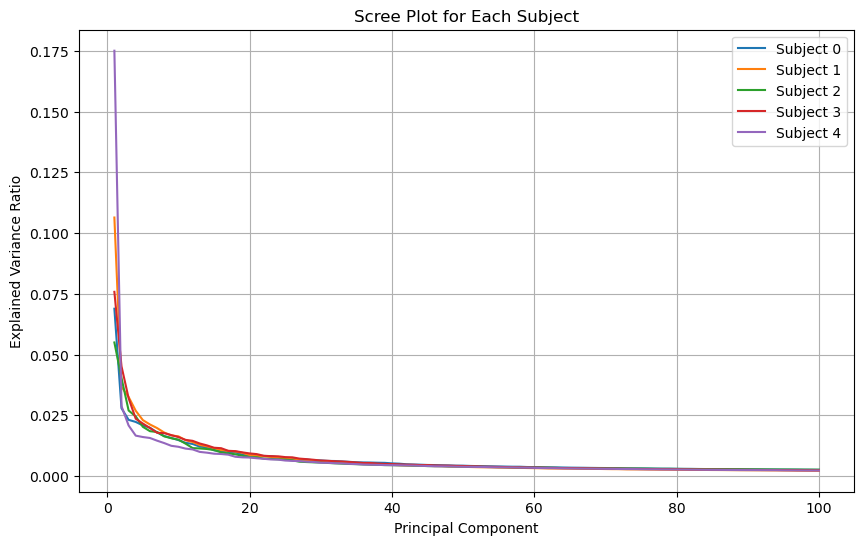

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# For storing explained variance ratios
subject_variance_ratios = []

# Loop over each subject's raw data
for subject_data in subject_list:  # shape: [n_voxels, 4, 600]
    samples = []

    for track_idx in range(60):
        for rep in range(4):
            t = track_idx * 10 + 8
            voxel_vector = subject_data[:, rep, t]
            samples.append(voxel_vector)

    subject_matrix = np.stack(samples)  # shape: [240, n_voxels]

    # Fit PCA for this subject
    pca = PCA(n_components=100)
    pca.fit(subject_matrix)

    # Store explained variance ratio
    subject_variance_ratios.append(pca.explained_variance_ratio_)

# --- Plot Scree Plots for Each Subject ---
plt.figure(figsize=(10, 6))
for idx, var_ratio in enumerate(subject_variance_ratios):
    plt.plot(np.arange(1, len(var_ratio)+1), var_ratio, label=f"Subject {idx}")
    
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot for Each Subject")
plt.legend()
plt.grid(True)
plt.show()


Good signs:
Sharp drop-off in the first ~10 components
→ This means a lot of the signal is concentrated early on — great for dimensionality reduction!

Elbow shape around component 10–20
→ This is where the "important variance" starts to level off

Very flat tail after ~50 components
→ Components 50–100 barely explain anything new

In [8]:
def run_umap_at_timepoint(offset=8, pca_components=100):
    all_subjects_pca = []
    all_subject_ids = []

    for subject_idx, subject_data in enumerate(subject_list):
        samples = []
        for track_idx in range(60):
            for rep in range(4):
                t = track_idx * 10 + offset
                if t >= subject_data.shape[2]:
                    continue  # skip if timepoint is out of bounds
                voxel_vector = subject_data[:, rep, t]
                samples.append(voxel_vector)

        subject_matrix = np.stack(samples)  # shape: [240, n_voxels]

        # Run PCA per subject to reduce to same # of dimensions
        pca = PCA(n_components=pca_components)
        subject_matrix_pca = pca.fit_transform(subject_matrix)  # shape: [240, 100]

        all_subjects_pca.append(subject_matrix_pca)
        all_subject_ids.extend([subject_idx] * subject_matrix_pca.shape[0])

    data_matrix = np.vstack(all_subjects_pca)  # shape: [1200, 100]
    subject_ids = np.array(all_subject_ids)

    # UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(data_matrix)

    return embedding, subject_ids

Put the above into UMAP:

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP plots...


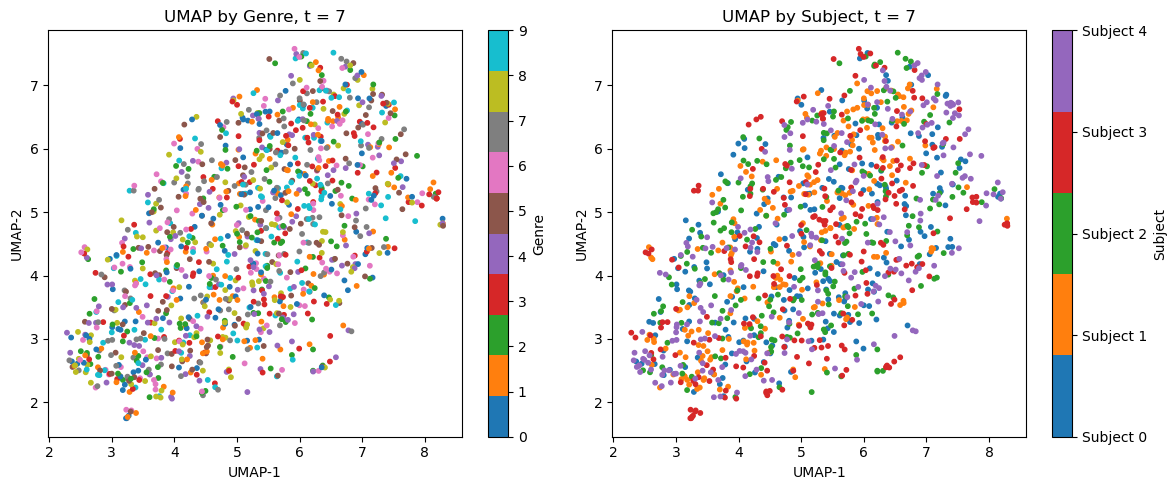

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# --- Step 1: UMAP from 100D → 2D ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding, subject_ids = run_umap_at_timepoint(offset=7)


# --- Step 2: Encode genre labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_1200)

# --- Step 3: Create custom colormap for 5 subjects ---
subject_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# --- Step 4: Plot both genre and subject ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
print("Generating UMAP plots...")
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre, t = 7")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar1 = plt.colorbar(scatter1, ticks=range(10))
cbar1.set_label("Genre")

# -- Plot by Subject (with fixed 5-color map) --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap=subject_cmap, s=10)
plt.title("UMAP by Subject, t = 7")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar2 = plt.colorbar(scatter2, ticks=range(5))
cbar2.set_label("Subject")
cbar2.set_ticklabels([f"Subject {i}" for i in range(5)])

plt.tight_layout()
plt.show()

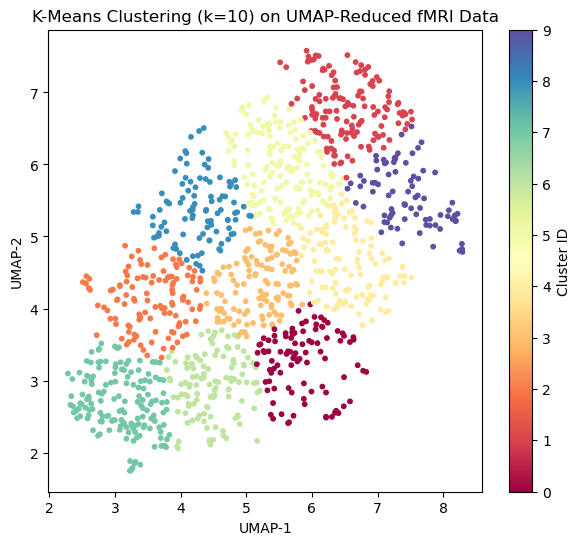

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Run KMeans on your UMAP embedding (2D)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)  # embedding: [n_samples, 2]

# Step 2: Visualize clusters
plt.figure(figsize=(7, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='Spectral', s=10)
plt.title("K-Means Clustering (k=10) on UMAP-Reduced fMRI Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()


In [11]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(genre_labels_named_1200, kmeans_labels)
ami = adjusted_mutual_info_score(genre_labels_named_1200, kmeans_labels)

print(f"ARI: {ari:.3f} | AMI: {ami:.3f}")


ARI: 0.000 | AMI: 0.000


Let's UMAP per subject:

In [12]:
def run_subjectwise_umap(offset=8):
    """
    Runs UMAP for each subject individually (no PCA).
    
    Parameters:
        offset (int): Time offset into each 10-point track (0–9)

    Returns:
        subject_embeddings: List of [240, 2] UMAP arrays (one per subject)
    """
    subject_embeddings = []

    for subject_idx, subject_data in enumerate(subject_list):
        samples = []

        for track_idx in range(60):
            for rep in range(4):
                t = track_idx * 10 + offset
                if t >= subject_data.shape[2]:
                    continue
                voxel_vector = subject_data[:, rep, t]
                samples.append(voxel_vector)

        subject_matrix = np.stack(samples)  # shape: [240, n_voxels]

        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        subject_embedding = reducer.fit_transform(subject_matrix)

        subject_embeddings.append(subject_embedding)

    return subject_embeddings

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/vh/3v1sh3tj3ql1_knpdx6s4c8r0000gn/T/ipykernel_64506/2039040489.py:31: UserWarning: This figure includes Axes that are not compatible with

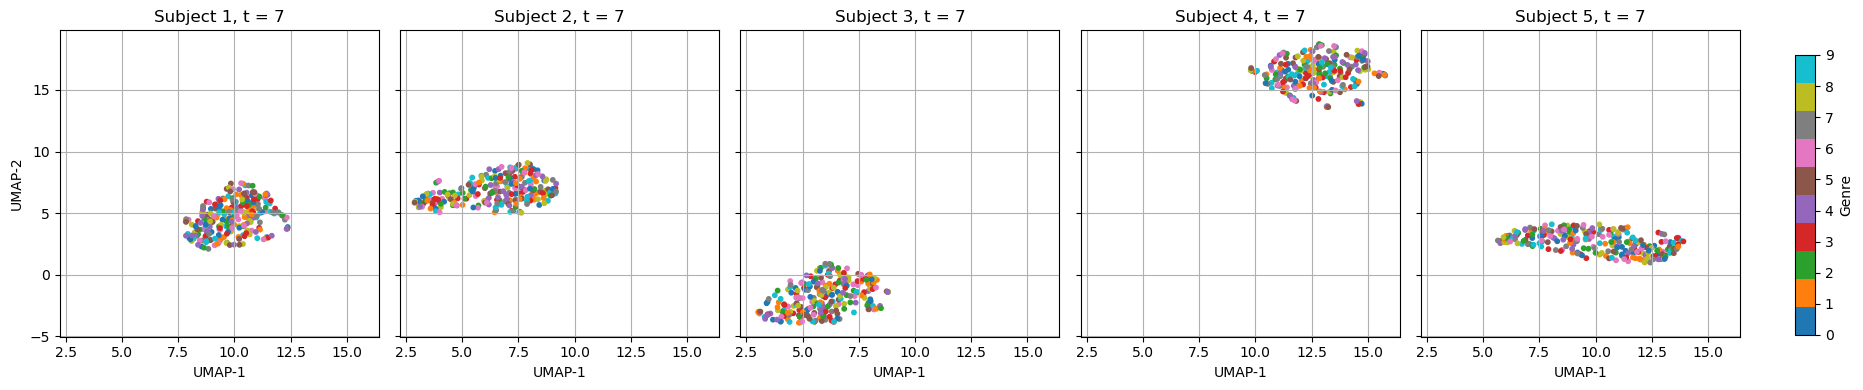

In [13]:
# Already have:
# genre_labels_named → shape [240]
# subject_list → list of 5 arrays, each [n_voxels, 4, 600]

genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_240)

# Step 1: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = run_subjectwise_umap(7)
    
# Set up one row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for subject_idx, subject_embedding in enumerate(embedding):
    ax = axes[subject_idx]
    sc = ax.scatter(subject_embedding[:, 0], subject_embedding[:, 1],
                    c=genre_encoded, cmap='tab10', s=10)
    ax.set_title(f"Subject {subject_idx + 1}, t = 7")
    ax.set_xlabel("UMAP-1")
    if subject_idx == 0:
        ax.set_ylabel("UMAP-2")
    ax.grid(True)

# Add one shared colorbar on the side
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, ticks=range(10))
cbar.set_label("Genre")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


***Let's run this on different timepoints:***

***timepoint 1***

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP plots...


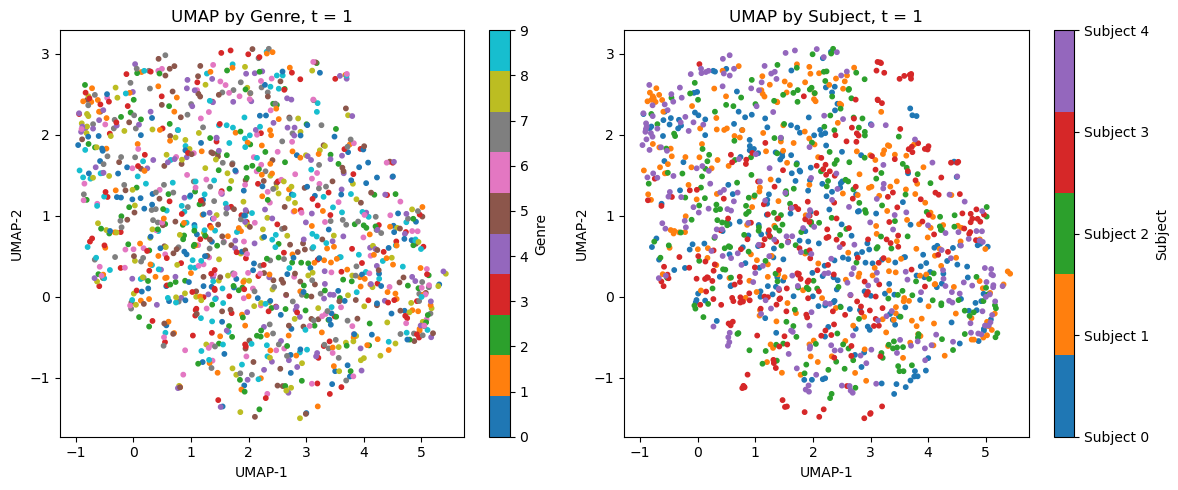

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# --- Step 1: UMAP from 100D → 2D ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding, subject_ids = run_umap_at_timepoint(offset=1)


# --- Step 2: Encode genre labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_1200)

# --- Step 3: Create custom colormap for 5 subjects ---
subject_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# --- Step 4: Plot both genre and subject ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
print("Generating UMAP plots...")
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre, t = 1")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar1 = plt.colorbar(scatter1, ticks=range(10))
cbar1.set_label("Genre")

# -- Plot by Subject (with fixed 5-color map) --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap=subject_cmap, s=10)
plt.title("UMAP by Subject, t = 1")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar2 = plt.colorbar(scatter2, ticks=range(5))
cbar2.set_label("Subject")
cbar2.set_ticklabels([f"Subject {i}" for i in range(5)])

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/vh/3v1sh3tj3ql1_knpdx6s4c8r0000gn/T/ipykernel_64506/2380953897.py:27: UserWarning: This figure includes Axes that are not compatible with

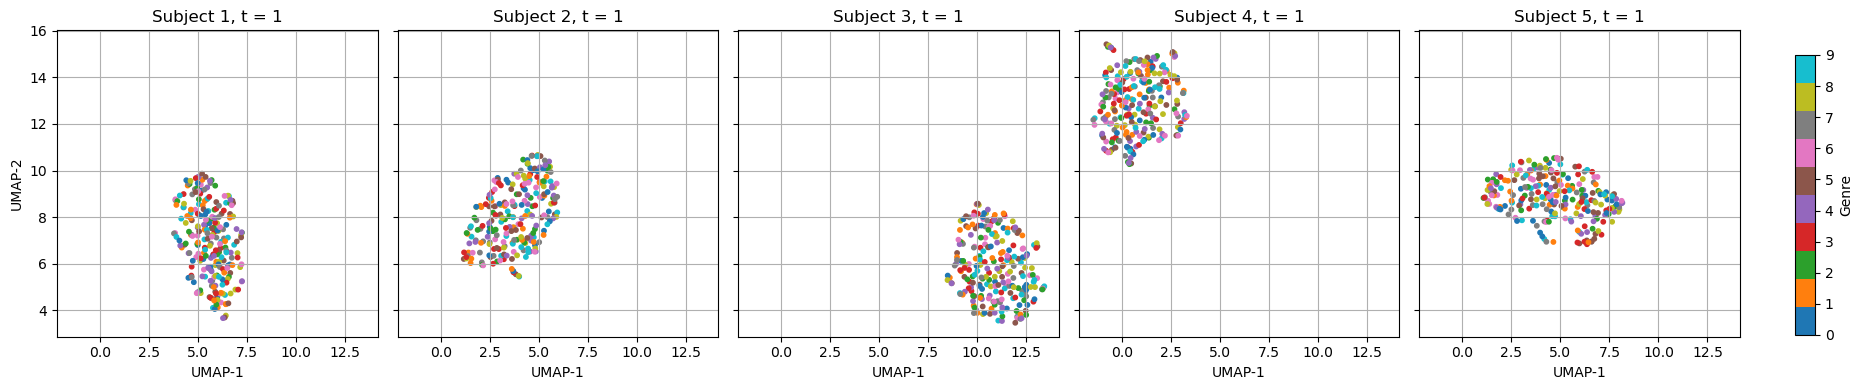

In [15]:
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_240)

# Step 1: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = run_subjectwise_umap(1)
    
# Set up one row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for subject_idx, subject_embedding in enumerate(embedding):
    ax = axes[subject_idx]
    sc = ax.scatter(subject_embedding[:, 0], subject_embedding[:, 1],
                    c=genre_encoded, cmap='tab10', s=10)
    ax.set_title(f"Subject {subject_idx + 1}, t = 1")
    ax.set_xlabel("UMAP-1")
    if subject_idx == 0:
        ax.set_ylabel("UMAP-2")
    ax.grid(True)

# Add one shared colorbar on the side
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, ticks=range(10))
cbar.set_label("Genre")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

**timepoint 5**

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP plots...


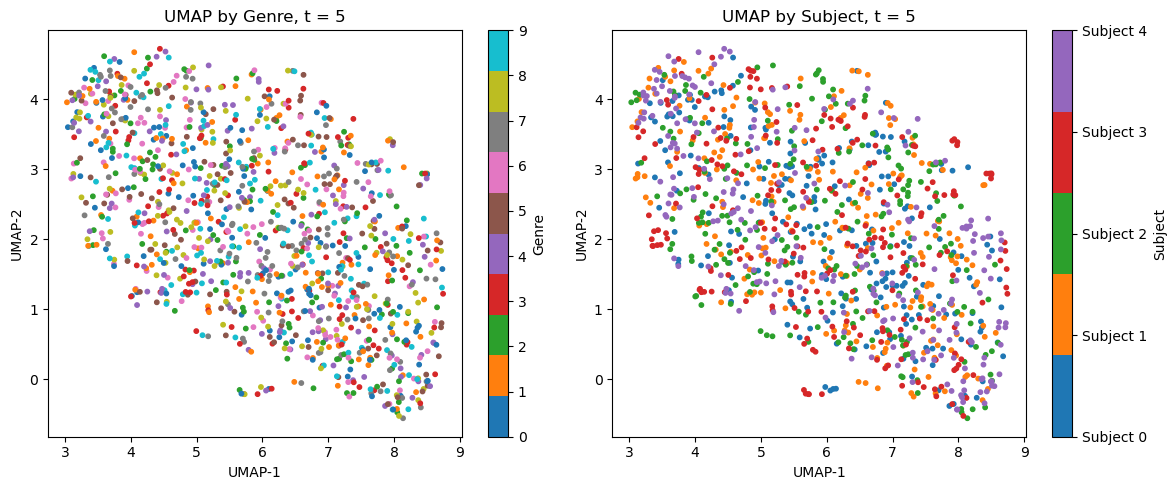

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# --- Step 1: UMAP from 100D → 2D ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding, subject_ids = run_umap_at_timepoint(offset=5)


# --- Step 2: Encode genre labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_1200)

# --- Step 3: Create custom colormap for 5 subjects ---
subject_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# --- Step 4: Plot both genre and subject ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
print("Generating UMAP plots...")
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre, t = 5")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar1 = plt.colorbar(scatter1, ticks=range(10))
cbar1.set_label("Genre")

# -- Plot by Subject (with fixed 5-color map) --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap=subject_cmap, s=10)
plt.title("UMAP by Subject, t = 5")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar2 = plt.colorbar(scatter2, ticks=range(5))
cbar2.set_label("Subject")
cbar2.set_ticklabels([f"Subject {i}" for i in range(5)])

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/vh/3v1sh3tj3ql1_knpdx6s4c8r0000gn/T/ipykernel_64506/1265152129.py:27: UserWarning: This figure includes Axes that are not compatible with

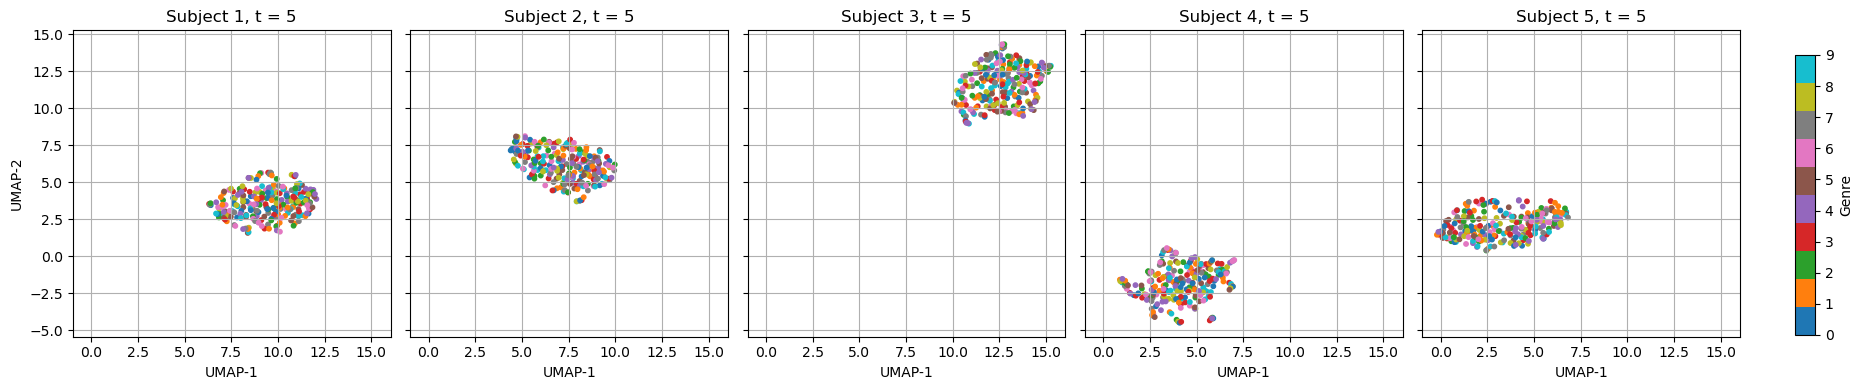

In [17]:
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_240)

# Step 1: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = run_subjectwise_umap(5)
    
# Set up one row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for subject_idx, subject_embedding in enumerate(embedding):
    ax = axes[subject_idx]
    sc = ax.scatter(subject_embedding[:, 0], subject_embedding[:, 1],
                    c=genre_encoded, cmap='tab10', s=10)
    ax.set_title(f"Subject {subject_idx + 1}, t = 5")
    ax.set_xlabel("UMAP-1")
    if subject_idx == 0:
        ax.set_ylabel("UMAP-2")
    ax.grid(True)

# Add one shared colorbar on the side
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, ticks=range(10))
cbar.set_label("Genre")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

**timestep 9**

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP plots...


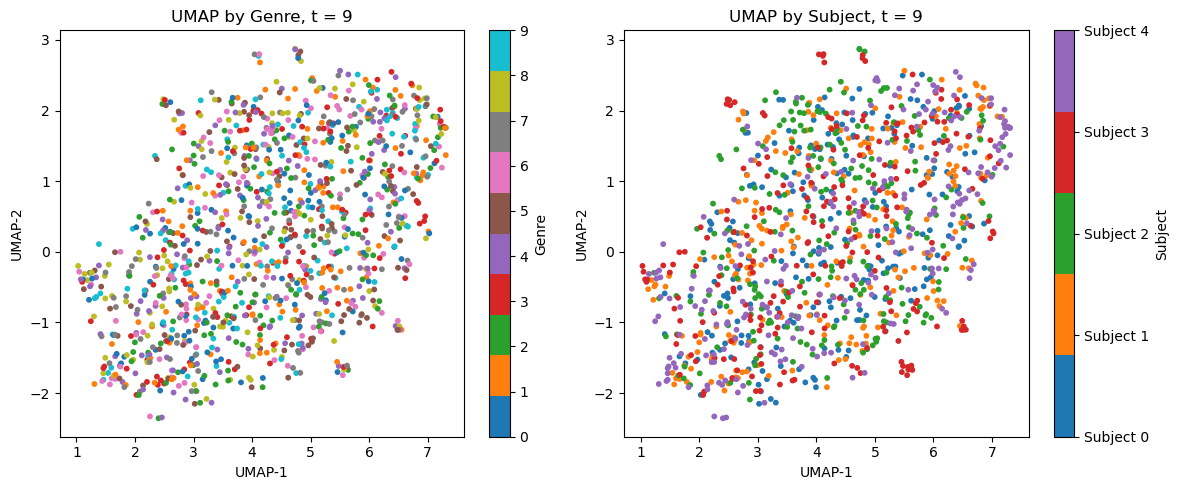

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# --- Step 1: UMAP from 100D → 2D ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding, subject_ids = run_umap_at_timepoint(offset=9)


# --- Step 2: Encode genre labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_1200)

# --- Step 3: Create custom colormap for 5 subjects ---
subject_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# --- Step 4: Plot both genre and subject ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
print("Generating UMAP plots...")
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre, t = 9")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar1 = plt.colorbar(scatter1, ticks=range(10))
cbar1.set_label("Genre")

# -- Plot by Subject (with fixed 5-color map) --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap=subject_cmap, s=10)
plt.title("UMAP by Subject, t = 9")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar2 = plt.colorbar(scatter2, ticks=range(5))
cbar2.set_label("Subject")
cbar2.set_ticklabels([f"Subject {i}" for i in range(5)])

plt.tight_layout()
plt.show()

In [19]:
# Already have:
# genre_labels_named → shape [240]
# subject_list → list of 5 arrays, each [n_voxels, 4, 600]

genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_240)

# Step 1: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = run_subjectwise_umap(9)
    
# Set up one row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for subject_idx, subject_embedding in enumerate(embedding):
    ax = axes[subject_idx]
    sc = ax.scatter(subject_embedding[:, 0], subject_embedding[:, 1],
                    c=genre_encoded, cmap='tab10', s=10)
    ax.set_title(f"Subject {subject_idx + 1}, t = 9")
    ax.set_xlabel("UMAP-1")
    if subject_idx == 0:
        ax.set_ylabel("UMAP-2")
    ax.grid(True)

# Add one shared colorbar on the side
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, ticks=range(10))
cbar.set_label("Genre")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

Ok, so we aren't seeing significant clustering across time points so let's try a different approach. 

average voxels across a period

Here, we are reshaping the data so that it's containing the first 3 repetitions. The last one will be kept for testing.

Each repetition has 60 tracks: 10 tracks per run. We are concatentating 3 repetitions of these 60 tracks. That will total to 180 tracks total.

In [78]:
sub1test_reshaped = np.transpose(sub1test[:, :3, :].reshape(voxels, 3, tracks, timepoints_per_track), [0,3,2,1]).reshape(voxels*timepoints_per_track,tracks*3)
sub1test_reshaped.shape

(607840, 180)

This will be structured as track 1 rep 1, track 1 rep 2, track 1 rep 3, track 2 rep 1, etc

Check that it was reshaped correctly. These two should print the same thing.

In [76]:
sub1test_reshaped[1000:1010, 5] 

array([-2.1766996 , -1.3379544 ,  1.5976536 , -0.91858184, -0.91858184,
       -0.4992093 ,  0.7589084 , -0.4992093 , -0.4992093 ,  1.1782811 ],
      dtype=float32)

In [79]:
sub1test[100, 0, 50:60]

array([-2.1766996 , -0.4992093 ,  1.5976536 ,  0.33953583, -0.07983673,
       -0.07983673, -0.4992093 ,  1.1782811 , -0.4992093 ,  1.5976536 ],
      dtype=float32)

sub1test_reshaped format:

(607840, 60): voxels * 10 timepoints, 60 tracks
 
 all timesteps for first voxel, all timesteps for second voxel, stacked. then by track

 need to do that for the first three reptitions. save the last one for testing

 full shape should be (voxels * )

In [44]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Move the time dimension to be part of the features
# Result: shape (voxels * timepoints_per_track, tracks)
# X_tracks = reshaped.transpose(0, 1, 2).reshape(voxels * timepoints_per_track, tracks)

clf = LogisticRegression(random_state=0).fit(sub1test_reshaped.T, genre_labels)

In [48]:
clf.predict(sub1test_reshaped[:, 0:1].T)

array([10])

In [ ]:
genre_labels[0]

10

inspect the weights to see what it's sensitive to. some weights may be high (timesteps * voxels)

maybe theres a time step or voxel where the weight is particularly high

make a new genre vector to fit the t1r1, t1r2, t1r3, t2t1, etc.